# Project Report: Which is the PULSAR
**DSCI 100 (007-34) Group Project Report**  
Group members:
- Elliot Saha
- Alasdair Buchanan
- Sarah Trevisan
- Minghao Li

## 1. Introduction

### 1.1 Background Information
Pulsars are high-magnetized neutron stars that spin at accurately constant speeds (Wikimedia Foundation, 2024). Because of this unique property, they are widely used in scientific research. However, it can be very challenging to identify their signals due to space noises.

### 1.2 Research Question
Our research question is:  
**Which candidate star will be a pulsar? How can we identify a pulsar given its radiation profile?**


### 1.3 Dataset
We will use [HTRU2 dataset](https://archive.ics.uci.edu/dataset/372/htru2) (Lyon et al., 2016). to classify pulsar stars. The dataset contains `Integrated Profile` and `DM-SNR curve` records for pulsar candidates.

- `Integrated profile` is a continuous sequence of measurements that describes the pulse signal received over time.
- `DM-SNR curve` is the curve showing the signal-to-noise ratio between the pulse and background radiation emissions.  
The author of this dataset compressed these arrays into 8 single variables (mean, standard deviation, kurtosis, and skewness for each of these two arrays).

## 2. Methods & Results
In this section, we will talk about our analysis process.

### 2.1 Method
Firstly, we will import all the necessary libraries and set a random seed to make sure the report is reproducible.

In [1]:
# import necessary libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(modeldata)
install.packages("themis")
library(themis)
# set random seed
set.seed(1111)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

Download data from our GitHub repository.

In [2]:
pulsar_data <- read_csv("https://raw.githubusercontent.com/Lmh-java/dsci-100-2023w2-group-034/main/data/HTRU_2.csv", col_names=FALSE)
sprintf("Table 1: Initial Glance at the Dataset")
head(pulsar_data)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1: Initial Glance at the Dataset"

X1,X2,X3,X4,X5,X6,X7,X8,X9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


#### 2.1.1 Data Wrangling
After the data is read from the source, we need to wrangle it for future analysis.

In [3]:
# rename the columns according to data/Readme.txt
pulsar_data <- pulsar_data |>
    rename(profile_mean = X1,
          profile_sd = X2,
          profile_kurtosis = X3,
          profile_skewness = X4,
          DM_SNR_mean = X5,
          DM_SNR_sd = X6,
          DM_SNR_kurtosis = X7,
          DM_SNR_skewness = X8,
          pulsar_star = X9) |> 
          # mark the label column as a categorical variable
          mutate(pulsar_star = as_factor(pulsar_star)) |>
          # pulsar_star refers to if the row is a pulsar star or not
          mutate(pulsar_star = fct_recode(pulsar_star, "true" = "1", "false" = "0"))
sprintf("Table 2: Second Glance at the Dataset with Correct Labels")
head(pulsar_data)

[1] "Table 2: Second Glance at the Dataset with Correct Labels"

profile_mean,profile_sd,profile_kurtosis,profile_skewness,DM_SNR_mean,DM_SNR_sd,DM_SNR_kurtosis,DM_SNR_skewness,pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,false
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,false
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,false
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,false
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,false
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,false


In [4]:
# We divide the dataset into training and testing subsets. The training set is 70% of the entire dataset, while the testing set takes the other 30%.
pulsar_split <- initial_split(pulsar_data, prop = 0.7, strata = pulsar_star)  
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)
sprintf("Table 3: Training Dataset")
head(pulsar_train)
sprintf("Table 4: Testing Dataset")
head(pulsar_test)

[1] "Table 3: Training Dataset"

profile_mean,profile_sd,profile_kurtosis,profile_skewness,DM_SNR_mean,DM_SNR_sd,DM_SNR_kurtosis,DM_SNR_skewness,pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
102.5078,58.88243,0.46531815,-0.5150879,1.6772575,14.860146,10.576487,127.39358,false
136.7500,57.17845,-0.06841464,-0.6362384,3.6429766,20.959280,6.896499,53.59366,false
119.4844,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,false
130.3828,39.84406,-0.15832276,0.3895404,1.2207358,14.378941,13.539456,198.23646,false
107.2500,52.62708,0.45268802,0.1703474,2.3319398,14.486853,9.001004,107.97251,false
107.2578,39.49649,0.46588196,1.1628771,4.0794314,24.980418,7.397080,57.78474,false


[1] "Table 4: Testing Dataset"

profile_mean,profile_sd,profile_kurtosis,profile_skewness,DM_SNR_mean,DM_SNR_sd,DM_SNR_kurtosis,DM_SNR_skewness,pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.69964840,3.199833,19.11043,7.975532,74.24222,false
103.01562,39.34165,0.32332837,1.05116443,3.121237,21.74467,7.735822,63.17191,false
88.72656,40.67223,0.60086608,1.12349169,1.178930,11.46872,14.269573,252.56731,false
93.57031,46.69811,0.53190485,0.41672112,1.636288,14.54507,10.621748,131.39400,false
138.17969,51.52448,-0.03185233,0.04679717,6.330268,31.57635,5.155940,26.14331,false
100.85156,51.74352,0.39383679,-0.01124074,2.841137,21.63578,8.302242,71.58437,false


`pulsar_train` is the cleaned training dataset for training our model. `pulsar_test` is the cleaned testing dataset for evaluating the final model. We need to summarize the training data to get a better insight for building the model. Firstly, we need to gather some basic information about the training data.
#### 2.1.2 Summary of Data

In [5]:
sprintf("Table 5: Glimpse of Training Dataset")
glimpse(pulsar_train)

[1] "Table 5: Glimpse of Training Dataset"

Rows: 12,528
Columns: 9
$ profile_mean     <dbl> 102.50781, 136.75000, 119.48438, 130.38281, 107.25000…
$ profile_sd       <dbl> 58.88243, 57.17845, 48.76506, 39.84406, 52.62708, 39.…
$ profile_kurtosis <dbl> 0.46531815, -0.06841464, 0.03146022, -0.15832276, 0.4…
$ profile_skewness <dbl> -0.51508791, -0.63623837, -0.11216757, 0.38954045, 0.…
$ DM_SNR_mean      <dbl> 1.6772575, 3.6429766, 0.9991639, 1.2207358, 2.3319398…
$ DM_SNR_sd        <dbl> 14.860146, 20.959280, 9.279612, 14.378941, 14.486853,…
$ DM_SNR_kurtosis  <dbl> 10.576487, 6.896499, 19.206230, 13.539456, 9.001004, …
$ DM_SNR_skewness  <dbl> 127.39358, 53.59366, 479.75657, 198.23646, 107.97251,…
$ pulsar_star      <fct> false, false, false, false, false, false, false, fals…


The training dataset has 12,528 rows and 9 columns (including the target label)  
Secondly, we need to ensure there are no `NA` values in the training dataset.

In [6]:
sprintf("Number of NAs: %s", sum(is.na(pulsar_train)))

[1] "Number of NAs: 0"

As shown above, there is no `NA` value in the dataset. Next, we need to take a look at the category distribution of the training set.

In [7]:
num_observations <- pulsar_train |>
    group_by(pulsar_star) |>
    summarize(num = n())
sprintf("Table 6: Number of Different Categories")
num_observations

[1] "Table 6: Number of Different Categories"

pulsar_star,num
<fct>,<int>
false,11400
true,1128


In the training set, the category `false` has 11400 observations, while the category `true` only has 1128 observations. Therefore, we must resample the training set to avoid model bias.  
Next, we will take a look at the average of each predictor.

In [8]:
avg_predictors <- pulsar_train |> 
    pivot_longer(profile_mean:DM_SNR_skewness, values_to="value", names_to="variable") |>
    group_by(variable) |>
    summarize(average = mean(value, na.rm=TRUE))
sprintf("Table 7: Mean of Variables")
avg_predictors

[1] "Table 7: Mean of Variables"

variable,average
<chr>,<dbl>
DM_SNR_kurtosis,8.2914408
DM_SNR_mean,12.4725362
DM_SNR_sd,26.2517152
DM_SNR_skewness,104.1450850
profile_kurtosis,0.4679873
profile_mean,111.3858407
profile_sd,46.6058129
profile_skewness,1.7283891


The average of predictors varies in a range from 0.468 to 111.386. This means some predictors are very spread out, so we must normalize the values before feeding the data to the model.
#### 2.1.3 Data Visualization

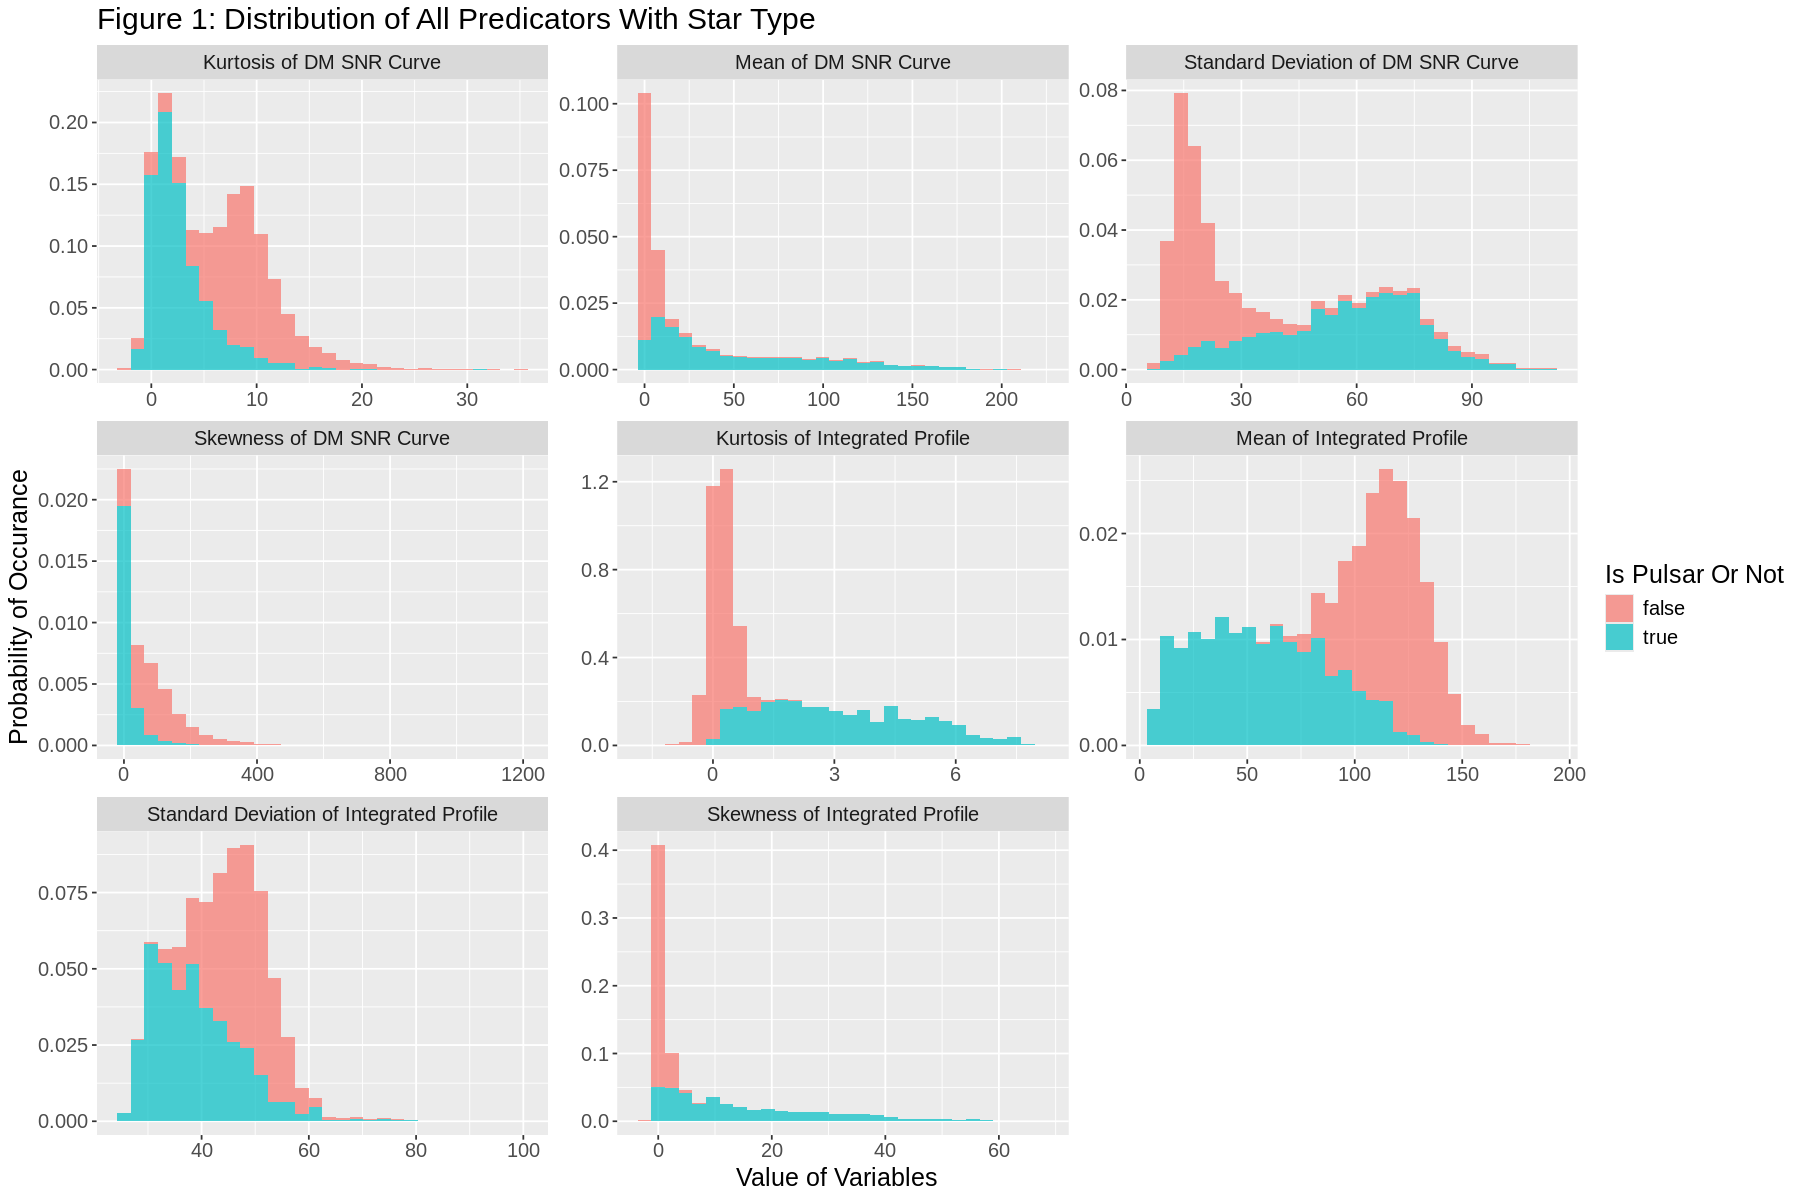

In [9]:
options(repr.plot.width = 15, repr.plot.height=10)

readable_var_names = c("DM_SNR_kurtosis" = "Kurtosis of DM SNR Curve", "DM_SNR_mean" = "Mean of DM SNR Curve", 
                       "DM_SNR_sd" = "Standard Deviation of DM SNR Curve", "DM_SNR_skewness" = "Skewness of DM SNR Curve", "profile_kurtosis" = "Kurtosis of Integrated Profile", 
                       "profile_mean" = "Mean of Integrated Profile", "profile_sd" = "Standard Deviation of Integrated Profile", "profile_skewness" = "Skewness of Integrated Profile")
distribution_plot <- pulsar_train |> 
    pivot_longer(profile_mean:DM_SNR_skewness, values_to="value", names_to="variable") |>
    ggplot(aes(x = value, fill = pulsar_star, y = after_stat(density))) +
    geom_histogram(bins=30, alpha=0.7) +
    facet_wrap(vars(variable), scales = "free", labeller=labeller(variable = readable_var_names)) +
    theme(text = element_text(size=15)) +
    labs(x = "Value of Variables", y = "Probability of Occurance", fill = "Is Pulsar Or Not") +
    ggtitle("Figure 1: Distribution of All Predicators With Star Type")
    
distribution_plot

In Figure 1, we plotted the distribution of every predictor separated by different label types. The red color marks the observations that are not pulsars, while the blue color marks the observations that are pulsars. We can use all the predictors for training the model since the distribution of these two labels is sufficiently different from each other, so the model can capture this difference to make better predictions.

#### 2.1.4 Model Training
Now, we have collected enough information about the dataset. It is the time to start training the model. We decided to use **K-nearest neighbors model** to perform the classification task.

Since there is a serious class imbalance in the training set, we need to resample it to balance class labels. To reduce the computational expense in the training process, we decided to use downsampling.

In [10]:
# Downsample the data
downsample_recipe <- recipe(pulsar_star ~ ., data=pulsar_train) |>
    step_downsample(pulsar_star, under_ratio=1) |>
    prep()

pulsar_train_downsampled <- downsample_recipe |>
    bake(new_data=NULL)

sprintf("Table 8: Glimpse of Downsampled Training Dataset")
glimpse(pulsar_train_downsampled)
sprintf("Table 9: Number of Different Categories after Downsampling")
count(pulsar_train_downsampled, pulsar_star)

[1] "Table 8: Glimpse of Downsampled Training Dataset"

Rows: 2,256
Columns: 9
$ profile_mean     <dbl> 111.29688, 83.54688, 104.53125, 130.39844, 127.58594,…
$ profile_sd       <dbl> 38.07853, 43.66954, 54.67831, 49.18481, 42.93482, 48.…
$ profile_kurtosis <dbl> 0.296122476, 0.659497694, 0.324195069, -0.136959764, …
$ profile_skewness <dbl> 1.11594614, 1.54798034, -0.26018972, -0.18154488, 0.9…
$ DM_SNR_mean      <dbl> 1.448161, 2.251672, 3.603679, 2.352843, 5.052676, 3.9…
$ DM_SNR_sd        <dbl> 12.91449, 18.10032, 18.95078, 15.24546, 26.67458, 24.…
$ DM_SNR_kurtosis  <dbl> 13.078862, 9.681227, 6.472968, 9.938688, 6.056888, 7.…
$ DM_SNR_skewness  <dbl> 203.978636, 102.513187, 50.121106, 118.027235, 38.560…
$ pulsar_star      <fct> false, false, false, false, false, false, false, fals…


[1] "Table 9: Number of Different Categories after Downsampling"

pulsar_star,n
<fct>,<int>
false,1128
true,1128


As Table 9 shows, after downsampling, both of the two classes have 1128 observations. The training set is perfectly balanced. We can set up a workflow to select the best `K` value for the model with 5 cross-validation.

In [11]:
# set up model specification
knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) |>
    set_mode("classification") |>
    set_engine("kknn")
# set up a recipe that also normalizes the data.
knn_recipe <- recipe(pulsar_star ~ ., data=pulsar_train_downsampled) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

In [12]:
# vfold model
pulsar_vfold <- vfold_cv(pulsar_train_downsampled, v = 5, strata = pulsar_star)

# K values to try
kvals <- tibble(neighbors=1:10)

# set up a workflow that assembles recipe and model
tuning_result <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples=pulsar_vfold, grid=kvals) |>
    collect_metrics()
sprintf("Table 10: The Most Accurate Model in Tuning")
tuning_result |>
    filter(.metric=="accuracy") |>
    arrange(desc(mean)) |>
    slice(1)

[1] "Table 10: The Most Accurate Model in Tuning"

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.9286391,5,0.001414828,Preprocessor1_Model09


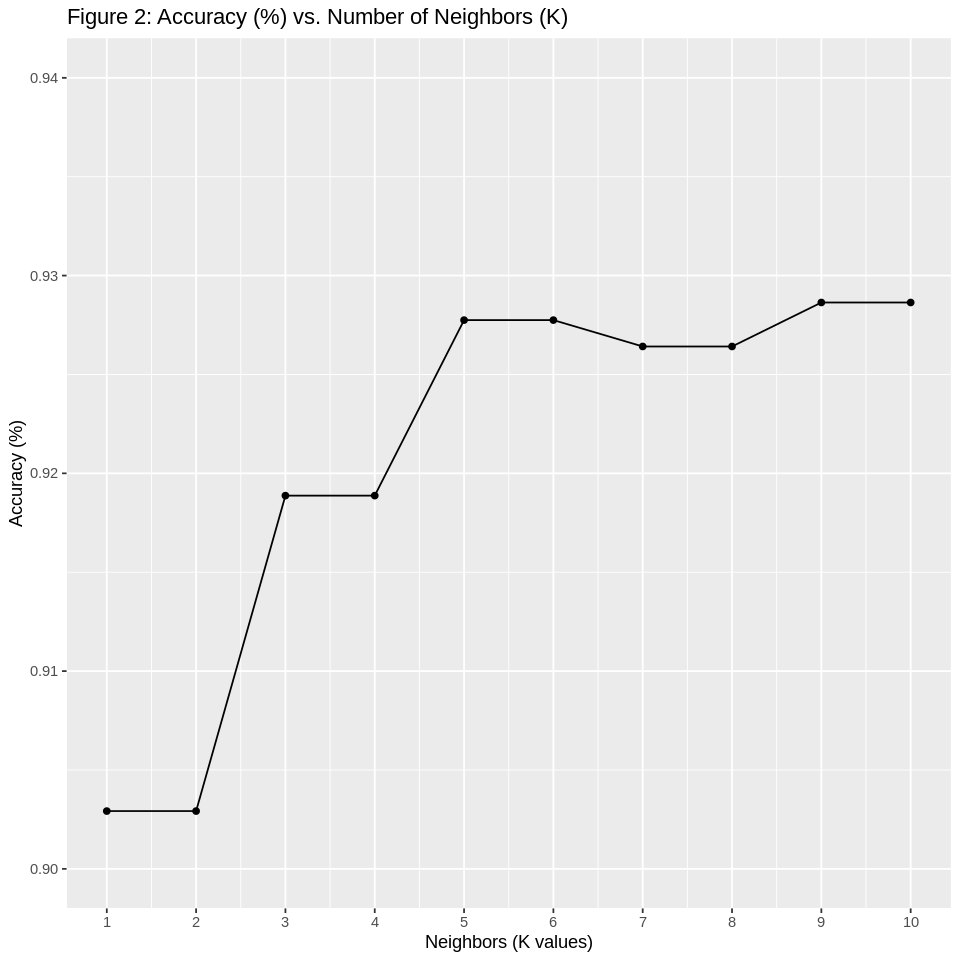

In [13]:
# Visualize the tuning result
options(repr.plot.width=8, repr.plot.height=8)
accuracy_plot <- tuning_result |>
      filter(.metric == "accuracy") |>
      ggplot(aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors (K values)", y = "Accuracy (%)") +
      scale_x_continuous(breaks = seq(1, 10, by = 1)) +
      scale_y_continuous(limits = c(0.90, 0.94)) +
      ggtitle("Figure 2: Accuracy (%) vs. Number of Neighbors (K)")
accuracy_plot

After visualizing the tuning result (Figure 2), when the model is using 9 neighbors, it will produce the best accuracy of around 92.9%. Therefore, we decided to use K=9 to train the model.

In [14]:
# pull the final k value
k <- tuning_result |>
    filter(.metric=="accuracy") |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(neighbors)

# final knn model
final_knn_spec <- nearest_neighbor(neighbor=k, weight_func="rectangular") |>
    set_mode("classification") |>
    set_engine("kknn")

final_model <- workflow() |>
    add_model(final_knn_spec) |>
    add_recipe(knn_recipe) |>
    fit(data = pulsar_train_downsampled)

### 2.2 Result

Now, the model `final_model` is successfully trained. We need to test its performance on the testing set.

In [15]:
# Predict the testing set.
test_prediction <- predict(final_model, pulsar_test) |>
    bind_cols(pulsar_test)

sprintf("Table 11: Testing Dataset with Prediction of Model")
head(test_prediction)

# confusion matrix
confusion_matrix <- conf_mat(test_prediction, truth = pulsar_star, estimate = .pred_class)
sprintf("Table 12: Confusion Matrix on Testing Dataset")
confusion_matrix

[1] "Table 11: Testing Dataset with Prediction of Model"

.pred_class,profile_mean,profile_sd,profile_kurtosis,profile_skewness,DM_SNR_mean,DM_SNR_sd,DM_SNR_kurtosis,DM_SNR_skewness,pulsar_star
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
false,140.56250,55.68378,-0.23457141,-0.69964840,3.199833,19.11043,7.975532,74.24222,false
false,103.01562,39.34165,0.32332837,1.05116443,3.121237,21.74467,7.735822,63.17191,false
false,88.72656,40.67223,0.60086608,1.12349169,1.178930,11.46872,14.269573,252.56731,false
false,93.57031,46.69811,0.53190485,0.41672112,1.636288,14.54507,10.621748,131.39400,false
false,138.17969,51.52448,-0.03185233,0.04679717,6.330268,31.57635,5.155940,26.14331,false
false,100.85156,51.74352,0.39383679,-0.01124074,2.841137,21.63578,8.302242,71.58437,false


[1] "Table 12: Confusion Matrix on Testing Dataset"

          Truth
Prediction false true
     false  4675   55
     true    184  456

In [16]:
# Calculate accuracy, recall, and precision
pulsar_metrics <- metrics(test_prediction, truth=pulsar_star, estimate=.pred_class) |>
    bind_rows(recall(test_prediction, truth=pulsar_star, estimate=.pred_class)) |>
    bind_rows(precision(test_prediction, truth=pulsar_star, estimate=.pred_class))

sprintf("Table 13: Metrics of the Model on Testing Dataset")
pulsar_metrics

[1] "Table 13: Metrics of the Model on Testing Dataset"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9554935
kap,binary,0.7677802
recall,binary,0.9621321
precision,binary,0.9883721


# Analysis of result

## 3. Discussion

### 3.1 Summary

When beginning this project, the initial research question that was posed was how can we identify what candidate stars could be pulsars, and how we can identify a pulsar given its radiation profile. We used the [HTRU2 dataset](https://archive.ics.uci.edu/dataset/372/htru2) to classify our pulsar stars. The first thing we did was wrangle and clean our initial dataset in order to provide readable column names to our data and allow filtering for the `pulsar_star` column by transforming it into a categorical variable. We divided our training and testing subsets accordingly and then resampled our training set in order to remove model bias. This was necessary as the amount of `false` observations was significantly larger than the amount of `true` observations in our training set. We then normalized our predictor values as there was a large range of values before feeding the data to our model. In order to properly take advantage of the K-nearest neighbors model to classify stars as pulsar or not, we decided to downsample our training set to prevent a major class imbalance.

When visualizing our tuning result (Figure 2), we found that setting **K=9** to train our model led to an **accuracy of 92.9%** for cross-validation.

After testing the performance of this model on the testing set, we can observe in our confusion matrix (table 11) that there was a relatively low number of false positives and false negatives allowing for accuracy, recall, and precision all to be **above 95%**. Because of the accuracy found when using our model against test data was higher than the cross-validation data, it indicates that our model can generalize very well and can perform with a very high degree of accuracy on data it has never seen before.

### 3.2 Alignment with Expectations

Our model is designed to identify pulsars based on the integrated profile and the DM-SNR curve of stars. Specifically, the dataset provided us with the mean, skewness, standard deviation, and kurtosis features of these two metrics. Considering the fact that we are able to achieve a higher accuracy when using our model against test data than it achieved when cross-validating, it is safe to say that we achieved our goal. We were able to achieve a 92.9% accuracy when cross-validating our model and a 95.5% accuracy when using our model against test data, showing that our group was properly able to create a model that effectively generalizes beyond the initial training dataset, exhibiting strong predictive capabilities in unseen scenarios. 


### 3.3 Impact of Findings

The instruments used to identify pulsar candidates provide researchers with large quantities of data that can be difficult to sort through (Zhang et al., 2020). Manual screening of the data can be quite inefficient, which is why classification models (such as the one above) are a better choice for the task. 

Our analysis found that the model we created to classify potential pulsars has an accuracy of 95.5%. This allows for the majority of potential pulsars to be correctly classified as such. A high accuracy is important as knowing the location of new pulsars can allow for more accurate recognition and a greater understanding of bodies in space. This can lead to insights regarding gravity and general relativity. Additionally, pulsars can provide information on the formation of black holes and the location of neighboring planets. 

According to our confusion matrix, the number of true predictions in our test data set was over 10 times greater than the number of false predictions, suggesting that only a small percent of pulsar candidates are identified as pulsars. This reaffirms the importance of creating models such as the one shown above in order to narrow down the number of candidates. Knowing which pulsar candidates are actual pulsars is crucial to the study of these stars and our understanding of the universe. 

### 3.4 Future Questions

This analysis leads us to ask:
What other variables may be included in the dataset to improve our model and more accurately predict the presence of pulsars? 
Can we further subcategorize pulsars based on their characteristics and this dataset?

## 4. References

Lyon, R. J., Stappers, B. W., Cooper, S., Brooke, J. M., & Knowles, J. D. (2016). Fifty Years of pulsar candidate selection: From simple filters to a new principled real-time classification approach. Monthly Notices of the Royal Astronomical Society, 459(1), 1104–1123. https://doi.org/10.1093/mnras/stw656

Saha, E., Buchanan, A., Trevisan, S., Li, M. (2024). Project Proposal: Which is the PULSAR. GitHub. https://github.com/Lmh-java/dsci-100-2023w2-group-034/blob/3750fe2afdbfa1e777f961d24d2e10ec9ae6263a/group_proposal.ipynb

Wikimedia Foundation. (2024, March 7). Pulsar. Wikipedia. https://en.wikipedia.org/wiki/Pulsar

Zhang, C. J., Shang, Z. H., Chen, W. M., Xie, L., & Miao, X. H. (2020, March 18). A review of Research on Pulsar candidate recognition based on machine learning. Procedia Computer Science. https://www.sciencedirect.com/science/article/pii/S1877050920301721 